In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [2]:
from torchvision import datasets, models, transforms, utils

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.misc as msc
from PIL import Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
batch_size = 64
lr = 0.001

D_ent = 100
D_length = 28
D_img = D_length ** 2
D_hidden = 28

In [6]:
trans = transforms.Compose([transforms.ToTensor(), ])

In [7]:
data = datasets.MNIST(root='../data/', train=True, transform=trans)

In [8]:
data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
def mnist():
    data = next(iter(data_loader))[0]
    return data.view(batch_size, D_img)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


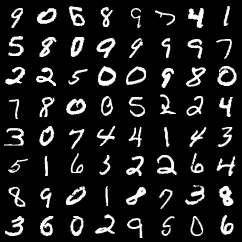

In [10]:
inputs = mnist().data.resize_(batch_size, 1, D_length, D_length)
out = utils.make_grid(inputs)
msc.toimage(out)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        #----1----#
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        #----2----#
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        #----3----#
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #----4----#
        res = F.sigmoid(x).view(-1, )
        return res

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 784)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc3(x)
        x = F.tanh(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [20]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    for num in range(10):
        for i in range(10):
            z = torch.randn(1, n_noise).to(device)
            y_hat = G(z)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    return img

In [21]:
D = Discriminator().to(device)
G = Generator().to(device)

In [22]:
criterion = nn.BCELoss()

In [23]:
D_opt = optim.Adam(D.parameters(), lr=lr)
G_opt = optim.Adam(G.parameters(), lr=lr)

In [24]:
ones = torch.ones(batch_size).to(device)
zeros = torch.zeros(batch_size).to(device)

In [25]:
step = 0
max_epoch = 100
dis_step = 3
log_interval = 1000

In [27]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        step += 1
        x = images.to(device)
        x_out = D(x)
        x_loss = criterion(x_out, ones)
        
        z = torch.randn(batch_size, 100).to(device)
        z_out = D(G(z))
        z_loss = criterion(z_out, zeros)
        
        D_loss = x_loss + z_loss
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % dis_step == 0:
            z = torch.randn(batch_size, 100).to(device)
            z_out = D(G(z))
            G_loss = criterion(z_out, ones)
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        if step % log_interval == 0:
            with torch.no_grad():
                G.eval()
                img = get_sample_image(G)
                msc.imsave("{}_{}_train.jpg".format(epoch, step), img)
                print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, 
                        max_epoch, step, D_loss.data.item(), G_loss.data.item()))

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Epoch: 0/100, Step: 100, D Loss: 0.354680597782135, G Loss: 3.019098997116089
Epoch: 0/100, Step: 150, D Loss: 0.27692899107933044, G Loss: 2.1797056198120117
Epoch: 0/100, Step: 200, D Loss: 0.20564648509025574, G Loss: 4.21758508682251
Epoch: 0/100, Step: 250, D Loss: 0.217204749584198, G Loss: 4.407502174377441
Epoch: 0/100, Step: 300, D Loss: 0.10466504096984863, G Loss: 3.606189012527466
Epoch: 0/100, Step: 350, D Loss: 0.13272249698638916, G Loss: 3.780078649520874
Epoch: 0/100, Step: 400, D Loss: 0.15327510237693787, G Loss: 2.904496669769287
Epoch: 0/100, Step: 450, D Loss: 0.04391951486468315, G Loss: 4.641870498657227
Epoch: 0/100, Step: 500, D Loss: 0.17584383487701416, G Loss: 4.444125652313232
Epoch: 0/100, Step: 550, D Loss: 0.0687825083732605, G Loss: 6.094211101531982
Epoch: 0/100, Step: 600, D Loss: 0.14445501565933228, G Loss: 6.256453037261963
Epoch: 0/100, Step: 650, D Loss: 0.0371900238096714, G Loss: 4.678792476654053
Epoch: 0/100, Step: 700, D Loss: 0.04543776437

KeyboardInterrupt: 